In [1]:
import sys
import pyccl as ccl
import numpy as np
from multiprocessing import Pool
import emcee
import matplotlib.pyplot as plt
import time
import pickle
import logging
import argparse
def binning(edges): return [[edges[i],edges[i+1]] for i in range(len(edges)-1)]

sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/')
import model_completeness as comp
import model_purity as pur
import model_halo_mass_function as hmf
import class_richness_mass_relation as rm_relation
import model_halo_abundance as cl_count
import model_stacked_cluster_mass as cl_mass
import pinocchio_mass_richness_relation as sim_mr_rel
import class_likelihood as likelihood
import pinocchio_binning_scheme as binning_scheme
import cluster_abundance_covariance as cl_covar

In [2]:
def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [3]:
# cosmology
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

In [4]:
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25) * 4 * np.pi
clc.f_sky = clc.sky_area/(4*np.pi)
z_grid = np.linspace(0.2, 1., 500)
logm_grid = np.linspace(14.2, 15.6, 501)
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)

In [5]:
Z_bin, logMass_bin = binning_scheme.Z_bin, binning_scheme.LogMass_bin
N = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')

In [6]:
halobias_fct = ccl.halos.hbias.tinker10.HaloBiasTinker10(mass_def=massdef, mass_def_strict=True)

In [7]:
clc.compute_halo_bias_grid_MZ(z_grid = z_grid, logm_grid = logm_grid, halobiais = halobias_fct)
NHalo_bias = clc.Nhalo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')

In [8]:
CLCovar = cl_covar.Covariance_matrix()
Sij_partialsky = CLCovar.compute_theoretical_Sij(Z_bin, cosmo, clc.f_sky)

In [9]:
Sample_covariance = CLCovar.sample_covariance_full_sky(Z_bin, logMass_bin, NHalo_bias, Sij_partialsky)

In [10]:
def run_simulation(N):
    N_mean = N
    dN_SSC = np.random.multivariate_normal( mean = np.zeros(len(Z_bin)*len(logMass_bin)) ,
                                           cov = Sample_covariance ).reshape(len(Z_bin),len(logMass_bin))
    N_obs = np.random.poisson(N_mean + dN_SSC)
    return N_obs

In [11]:
N_obs_list = []
for i in range(10000):
    N_obs_list.append(run_simulation(N))

In [12]:
data = load(f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_data_vector/data_vector_pinocchio_mock_mass-redshift_bins.pkl')

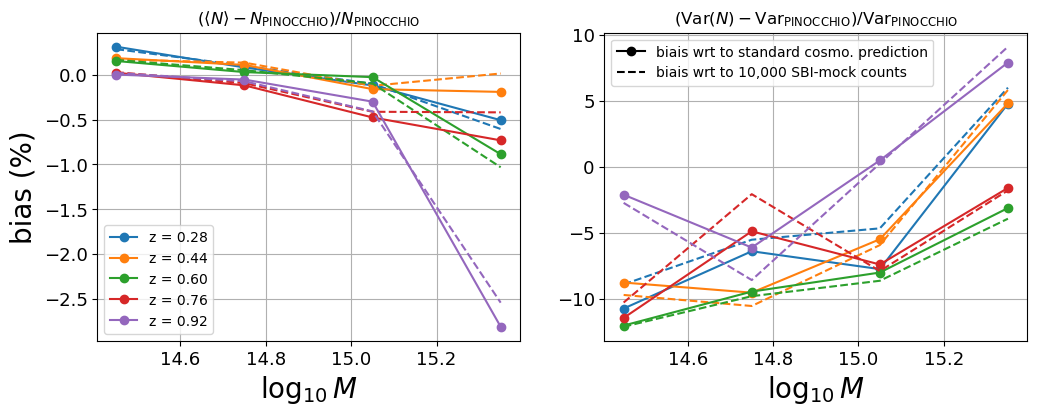

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)

for i in range(len(Z_bin)):
    from_sim = np.mean(np.array(N_obs_list).T[:,i], axis=1)
    from_pred = N[i,:]
    from_pinocchio = data['mean_count_mass_redshift'].T[i,:]
    plt.plot(np.mean(logMass_bin, axis=1), 100*(from_sim-from_pinocchio)/from_pinocchio, '-o'+'C' + str(i), label = 'z = '+f'{np.mean(Z_bin[i]):.2f}')
    plt.plot(np.mean(logMass_bin, axis=1), 100*(from_pred-from_pinocchio)/from_pinocchio, '--' + 'C' + str(i))
plt.title(r'$(\langle N \rangle - N_{\rm PINOCCHIO})/N_{\rm PINOCCHIO}$')
plt.ylabel('bias (%)', fontsize=20,)
plt.xlabel(r'$\log_{10}M$', fontsize=20,)
plt.grid(which='both')
plt.tick_params(axis='both', which = 'major', labelsize= 13)
plt.legend()

plt.subplot(122)
plt.title(r'$(\mathrm{Var}( N ) - \mathrm{Var}_{\rm PINOCCHIO})/\mathrm{Var}_{\rm PINOCCHIO}$')
for i in range(len(Z_bin)):
    from_sim = np.std(np.array(N_obs_list).T[:,i], axis=1)**2
    from_pred = N[i,:] + Sample_covariance.diagonal()[i*len(logMass_bin):(i+1)*len(logMass_bin)]
    from_pinocchio = data['err_mean_count_mass_redshift'].T[i,:]**2
    plt.plot(np.mean(logMass_bin, axis=1), 100*(from_sim-from_pinocchio)/from_pinocchio, '--'+'C' + str(i))
    plt.plot(np.mean(logMass_bin, axis=1), 100*(from_pred-from_pinocchio)/from_pinocchio, '-o' + 'C' + str(i))
    
plt.plot([], [], '-ok', label = 'biais wrt to standard cosmo. prediction')
plt.plot([], [], '--k', label = 'biais wrt to 10,000 SBI-mock counts')
plt.legend()

plt.xlabel(r'$\log_{10}M$', fontsize=20,)
plt.grid(which='both')
plt.tick_params(axis='both', which = 'major', labelsize= 13)